# Importing necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

**Details of dataset**

**Feature given**
1.   Age
2.   WorkClass
3.   fnlwgt
4.   Education
5.   Education_num
6.   Marital Status
7.   Occupation
8.   RelationShip
9.   Race
10.  Sex
11.  Capital gain
12.  Capital loss
13.  Hours per weeks
14.  Native country
15.   Income

**Feature created**


1.   Converted features into bool dtypes using pd.dummie() funtion
2.   Created some fetures for data analysis



In [ ]:
Cols=['Age', 'WorkClass', 'fnlwgt', 'Education', 'Education_num', 'Marital_Status', 'Occupation', 'Relationship',
               'Race', 'Sex', 'Capital_gain', 'Capital_loss', 'Hours_per_week', 'native_country', 'Income']

In [ ]:
training_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Income Dataset/adult.data', header=None, names=Cols, na_values=' ?')
testing_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Income Dataset/adult.test', header=None, names=Cols, na_values=' ?')

In [ ]:
training_data.head()

,Age,WorkClass,fnlwgt,Education,Education_num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,native_country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Data Prepartion

In [ ]:
testing_data.drop(index=0, inplace=True)
testing_data.reset_index(drop=True, inplace=True)
training_data.shape, testing_data.shape

((32561, 15), (16281, 15))

**Handling missing and null values**

In [ ]:
def cleaning_data(df):
  df.drop(columns=['fnlwgt'], inplace=True) # this data is not making more sense for my model
  df['Income'] = df['Income'].map({' <=50K': 0, ' >50K': 1, ' <=50K.':0, ' >50K.':1})
  df['WorkClass'].fillna('Unknown', inplace=True)
  df['Occupation'].fillna('Other-service', inplace=True)
  columns = ['Education', 'Education_num', 'Marital_Status', 'Relationship', 'Race', 'Sex', 'Income', 'Hours_per_week', 'Capital_gain', 'Capital_loss', 'native_country']
  for data in columns:
    df[data].fillna(df[data].mode()[0], inplace=True)
  df['Sex']=df['Sex'].map({' Male': 0, ' Female': 1})
  le = LabelEncoder()
  df['native_country'] = le.fit_transform(df['native_country'])
  df['Relationship'] = df['Relationship'].replace({
    ' Husband': 'Spouse',
    ' Wife': 'Spouse',
    ' Not-in-family': 'Single',
    ' Unmarried': 'Single',
    ' Other-relative': 'Others',
    ' Own-child': 'Others'
  })
  df['Marital_Status'] = df['Marital_Status'].replace({
      ' Never-married': 'Not-married',
      ' Married-civ-spouse': 'married',
      ' Married-AF-spouse': 'married',
      ' Divorced': 'previosly-married',
      ' Married-spouse-absent': 'previosly-married',
      ' Separated': 'previosly-married',
      ' Widowed': 'previosly-married'
  })

In [ ]:
cleaning_data(training_data)
cleaning_data(testing_data)

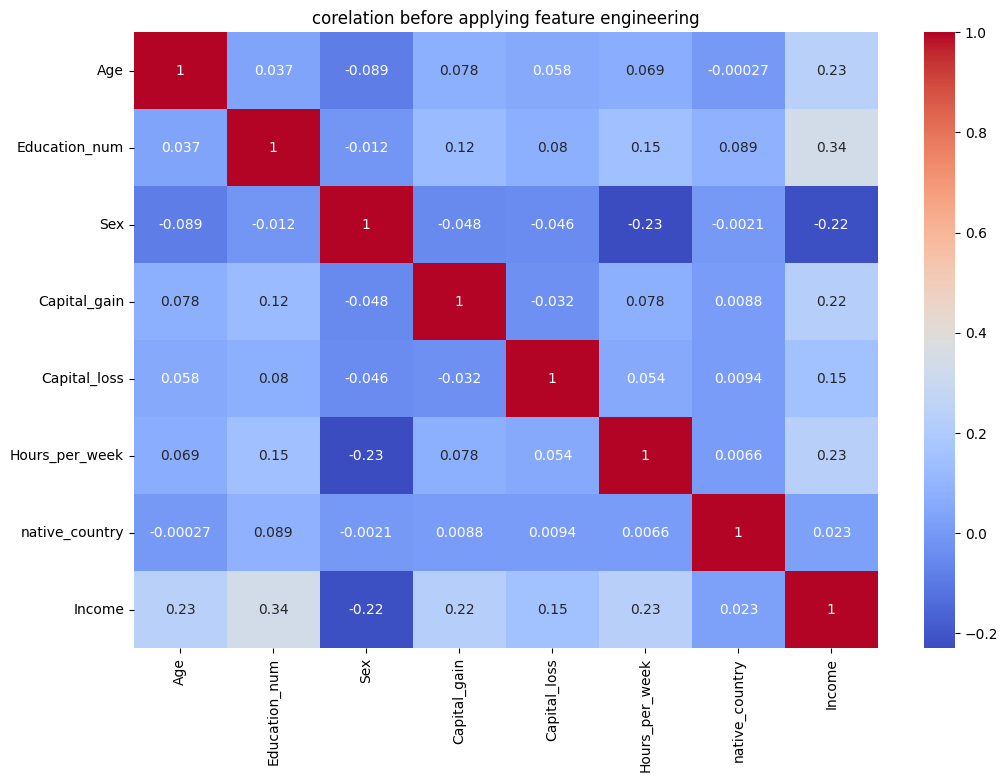

In [ ]:
numeric_df = training_data.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("corelation before applying feature engineering")
plt.show()

In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   WorkClass       32561 non-null  object
 2   Education       32561 non-null  object
 3   Education_num   32561 non-null  int64 
 4   Marital_Status  32561 non-null  object
 5   Occupation      32561 non-null  object
 6   Relationship    32561 non-null  object
 7   Race            32561 non-null  object
 8   Sex             32561 non-null  int64 
 9   Capital_gain    32561 non-null  int64 
 10  Capital_loss    32561 non-null  int64 
 11  Hours_per_week  32561 non-null  int64 
 12  native_country  32561 non-null  int64 
 13  Income          32561 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 3.5+ MB




1.   How many people work in which class?


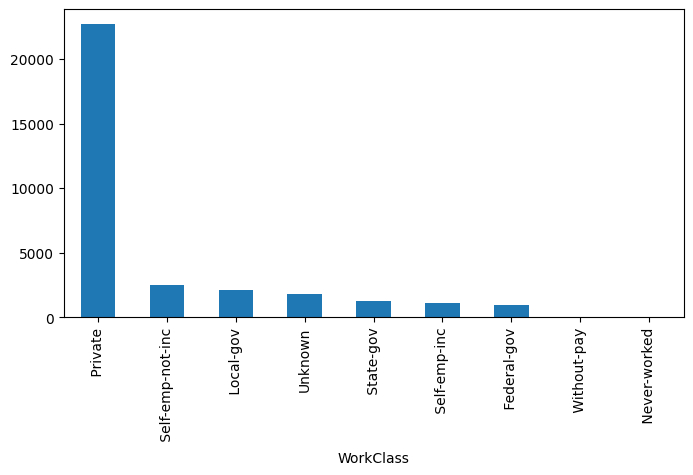

In [ ]:
plt.figure(figsize=(8,4))
training_data['WorkClass'].value_counts().plot(kind='bar')
plt.show()




2.   How many male and female in training dataset?



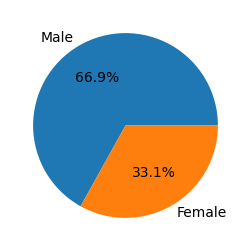

In [ ]:
fig = plt.figure(figsize=(3,3))
labels = 'Male', 'Female'
sizes = training_data['Sex'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.show()

**Feature Engineering**

In [ ]:
def feature_engineering(df):
    df.drop(index=0)
    df['Age'] = pd.to_numeric(df['Age'])
    df = pd.get_dummies(df, columns=['WorkClass', 'Occupation', 'Marital_Status', 'Relationship'], drop_first=True)
    df.drop(columns=['Education', 'Race', 'Sex'], axis=1, inplace=True) # these features are not much correlated with income
    return df


In [ ]:
train_df = feature_engineering(training_data)
test_df = feature_engineering(testing_data)

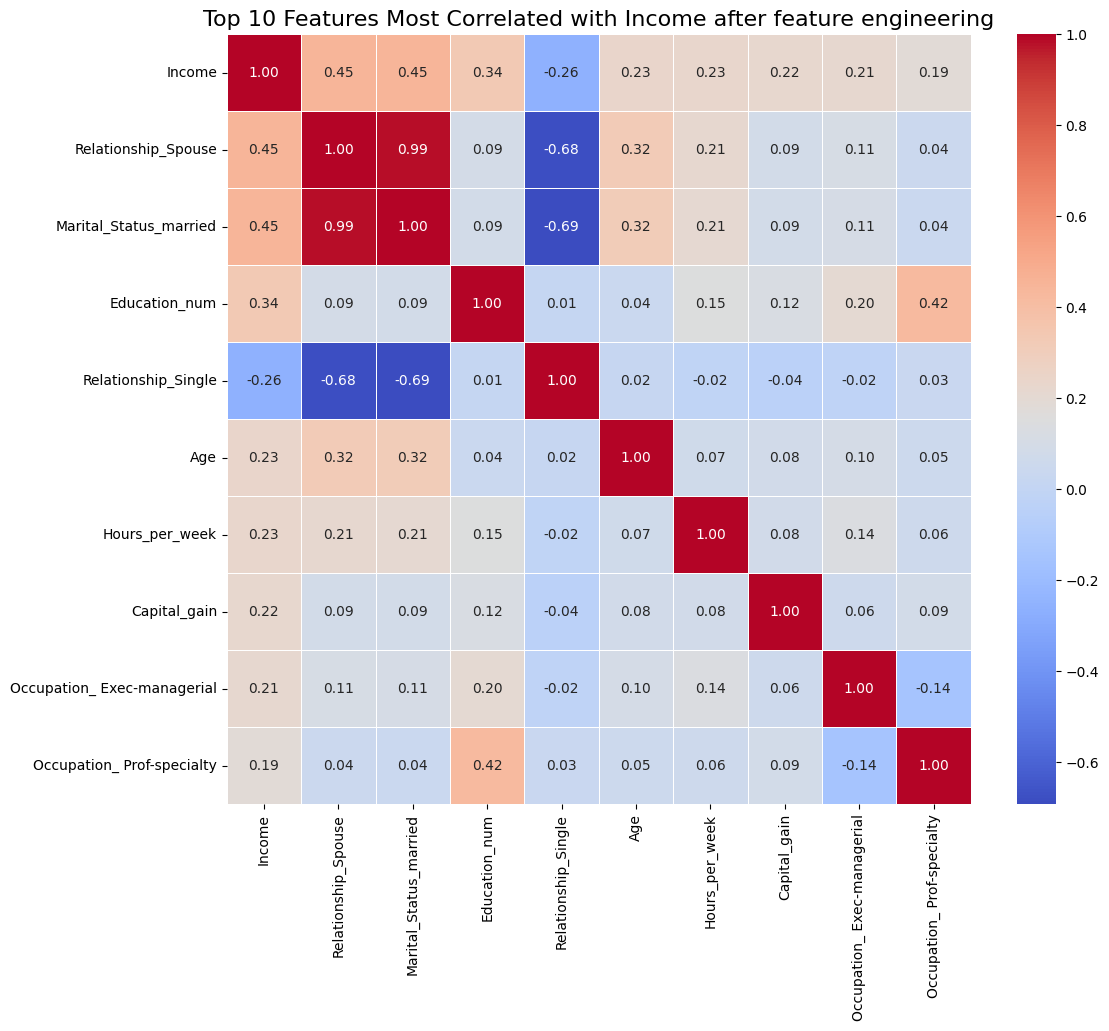

In [ ]:
corr_mat = train_df.select_dtypes(include=['int64', 'float64', 'bool']).corr()

top_10_features = corr_mat['Income'].abs().nlargest(10).index

corr_matrix = corr_mat.loc[top_10_features, top_10_features]

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Top 10 Features Most Correlated with Income after feature engineering", fontsize=16)
plt.show()

In [ ]:
x = train_df.drop('Income', axis=1)
y = train_df['Income']
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)
Logistic_model = LogisticRegression(class_weight='balanced', max_iter=1000)
Logistic_model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
x_test = test_df.drop('Income', axis=1)
y_test = test_df['Income']
y_pred = Logistic_model.predict(x_test)
val_score=Logistic_model.score(x_val, y_val)
print("Validation Score :", val_score)
test_score=Logistic_model.score(x_test, y_test)
print('Testing Score :', test_score)

Validation Score : 0.8030504657590337
Testing Score : 0.8061544131195872


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86     12435
           1       0.56      0.85      0.67      3846

    accuracy                           0.81     16281
   macro avg       0.75      0.82      0.77     16281
weighted avg       0.85      0.81      0.82     16281



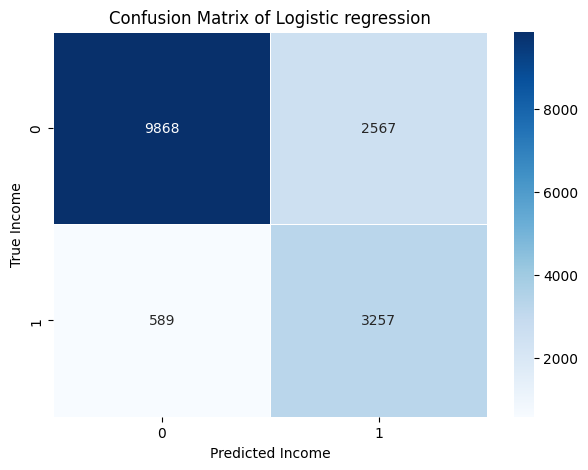

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Income")
plt.ylabel("True Income")
plt.title("Confusion Matrix of Logistic regression")
plt.show()

In [ ]:
count=train_df['Income'].value_counts()
class1 = count[0]
class2 = count[1]
weights = class1/class2
XGBClassifier_model = XGBClassifier(
    scale_pos_weight = weights,
    max_depth = 5,
    learning_rate = 0.1,
    n_estimators = 200,
    subsample = 0.8,
    colsample_bytree = 0.8,
    eval_metric = "logloss"
)

XGBClassifier_model.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred2 = XGBClassifier_model.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     12435
           1       0.64      0.82      0.72      3846

    accuracy                           0.85     16281
   macro avg       0.79      0.84      0.81     16281
weighted avg       0.87      0.85      0.85     16281



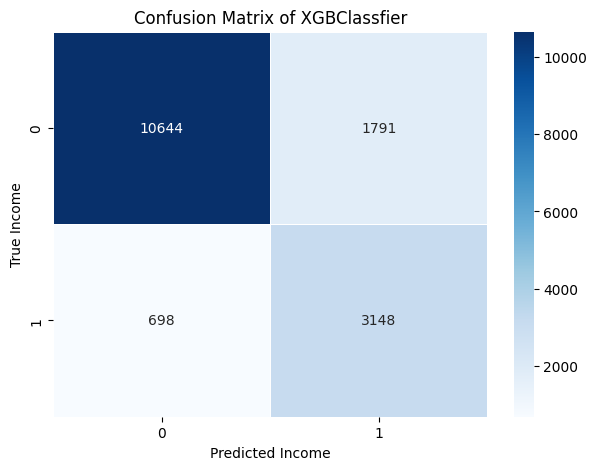

In [ ]:
cm = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Income")
plt.ylabel("True Income")
plt.title("Confusion Matrix of XGBClassfier")
plt.show()

In [ ]:
import pickle as pkl
pkl.dump(XGBClassifier_model, open('model.pkl', 'wb'))

# Explanation
The dataset used in this project was obtained from the UCI Machine Learning Repository, which provides separate files for training data, testing data, and additional metadata that describes each attribute in detail.

Adult Dataset: [link](https://archive.ics.uci.edu/dataset/2/adult)

To begin with, I performed data cleaning and preprocessing. This included identifying and handling missing or null values. Numerical missing values were processed by using the drop method where appropriate, while categorical missing values were filled using the mode of the respective columns to maintain consistency.

After cleaning the data, I generated a correlation matrix to examine the relationship between the target variable (income level) and the numerical features. Initially, the correlations were relatively low because the categorical variables were not yet encoded.

Next, I carried out feature engineering, where all categorical columns were converted into numerical format using the pd.get_dummies() function. This improved the dataset representation and allowed the model to better understand the categorical relationships.

With the transformed dataset, I again checked the correlation between income and all features. This time, the correlation values were more meaningful, helping me understand which variables had a stronger influence on income prediction.

For modeling, I first applied Logistic Regression, which is suitable for binary classification problems like this. However, the model initially performed poorly due to class imbalance in the dataset. To address this, I tuned Logistic Regression using parameters such as class_weight='balanced'. Though this improved performance slightly, the results were still not optimal.

Therefore, I experimented with a more advanced algorithm: XGBoost Classifier (XGBClassifier). I tuned several parameters manually and observed a significant improvement in accuracy, precision, recall, and overall model performance compared to Logistic Regression.

Once the model performance was satisfactory, I proceeded to save both the trained model and the preprocessing transformer using Python’s pickle module. This allowed seamless integration of the model into a Flask web application, where users can input their details and receive income predictions in real time.

Also, I am completed the Flask-based deployment, improving UI validation, and ensuring smooth data flow from HTML forms to the backend prediction pipeline.